In [34]:
#! conda install matplotlib torch pandas numpy scikit-learn torchvision tensorflow tensorboard tqdm seaborn biopython xgboost 
#! pip install jupyter-server-proxy viennaRNA torchsummary 

In [35]:
import datetime
import itertools
from typing import Literal, Optional

import Bio.Seq
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
from torchviz import make_dot
import tqdm
from xgboost import XGBRegressor, XGBClassifier
import ViennaRNA

import data_loading
import models
import train

In [7]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [8]:
df = data_loading.build_dataset('frameshift_data_natcomm.csv') #supplementary data 2 file of paper
df.head()

,gfp_minus_rate,gfp_plus_rate,sequence,variant_id,prf_class,gfp_minus,gfp_plus
1506,0.86,NaN,GATAGGTACCTGGCTGTCGTCCATGCTGTGTTTGCAAAAAAAGCCA...,37296,human - ccr5,False,False
1507,58.57,NaN,GATAGGTACCTGGCTGTCGTCCATGCTGTGTTTGCAAAAAACGCCA...,37297,human - ccr5,True,False
1508,NaN,71.48,GATAGGTACCTGGCTGTCGTCCATGCTGTGTTTGCAAAAAAGGCCA...,37298,human - ccr5,False,True
1509,NaN,1.30,GATAGGTACCTGGCTGTCGTCCATGCTGTGTTTGCAAAAAATGCCA...,37299,human - ccr5,False,False
1511,NaN,47.30,GATAGGTACCTGGCTGTCGTCCATGCTGTGTTTGCAAACCCCGCCA...,37301,human - ccr5,False,True


In [9]:
df['prf_class'].value_counts()

prf_class
HIV HXB2                             614
PLRV luteovirus                      612
human - OAZ1                         596
SARS coronavirus                     583
herpes simplex - thymidine kinase    582
human - PEG10                        575
simian srv1 retrovirus               562
human - HERV-K10                     525
Rous sarcoma virus                   511
influenza a virus                    456
synthetic                            450
SIVmac239                            450
west nile virus                      440
PRRSV - nsp2TF                       422
HCV - F protein                      378
human T-lymphotropic virus           369
human - ccr5                         276
Name: count, dtype: int64

In [10]:
PAPER_CAT = [
    'SARS coronavirus',
    'SIVmac239',
    'simian srv1 retrovirus',
    'PLRV luteovirus',
    'human - HERV-K10',
    'human T-lymphotropic virus',
    'HIV HXB2',
    'west nile virus',
    'mix'
]

In [11]:
baselines = {
    'mix': {
        'ROC-AUC/val': .89,
        'ROC-AUC/train': .89,
        'PR-AUC/val': .8,
        'PR-AUC/train': .8,
        'Pearson/val': .54,
        'Pearson/train': .54,
    },
    'SARS coronavirus': {
        'ROC-AUC/val': .63,
        'ROC-AUC/train': .63, 
        'Pearson/val': .24,
        'Pearson/train': .24,
    },
    'SIVmac239': {
        'ROC-AUC/val': .74,
        'ROC-AUC/train': .74,  
        'Pearson/val': .45,
        'Pearson/train': .45,
    },
    'simian srv1 retrovirus': {
        'ROC-AUC/val': .94,
        'ROC-AUC/train': .94,    
        'Pearson/val': .61,
        'Pearson/train': .61,
    },
    'PLRV luteovirus': {
        'ROC-AUC/val': .66,
        'ROC-AUC/train': .66,    
        'Pearson/val': .19,
        'Pearson/train': .19,
    },
    'human - HERV-K10': {
        'ROC-AUC/val': .85,
        'ROC-AUC/train': .85,   
        'Pearson/val': .63,
        'Pearson/train': .63,
    },
    'human T-lymphotropic virus': {
        'ROC-AUC/val': .88,
        'ROC-AUC/train': .88,   
        'Pearson/val': .39,
        'Pearson/train': .39,
    },
    'HIV HXB2': {
        'ROC-AUC/val': .89,
        'ROC-AUC/train': .89,      
        'Pearson/val': .69,
        'Pearson/train': .69,
    },
    'west nile virus': {
        'ROC-AUC/val': .47,
        'ROC-AUC/train': .47,   
        'Pearson/val': .61,
        'Pearson/train': .61,
    },
    
}

In [12]:
def secondary_features(sequence: str):
    _MAPPING = {'.': 0, '(': 1, ')': 1} 
    folded, _ = ViennaRNA.fold(sequence)
    encoded = [_MAPPING[pos] for pos in folded]
    return encoded

In [13]:
def aa_polarity_features(sequence: str):
    _AA_POLARITY = {
        'R':'charged',
        'H':'charged',
        'K':'charged',
        'D':'charged',
        'E':'charged',
        'S':'polar',
        'T':'polar',
        'N':'polar',
        'Q':'polar',
        'C':'polar',
        'Y':'polar',
        'G':'unpolar',
        'P':'unpolar',
        'A':'unpolar',
        'V':'unpolar',
        'I':'unpolar',
        'L':'unpolar',
        'M':'unpolar',
        'F':'unpolar',
        'W':'unpolar',
        '*':'stop'
    }
    translated = Bio.Seq.Seq(df.iloc[0].sequence).translate()
    polarity = [_AA_POLARITY[aa] for aa in translated]
    return polarity

In [14]:
tai_availability = pd.read_csv('tAI_index_human_nar-02315.txt', sep='\t').rename(columns={'w ': 'w'})
tai_availability.loc[:, 'w'] = tai_availability.loc[:, 'w'].map(lambda x: 0.0 if '----' in x else float(x))
tai_dict = dict(zip(tai_availability['Codon'], tai_availability['w']))
#tai_dict

In [15]:
def mikl_tai(df, tai_file):
    tai_availability = pd.read_csv(tai_file, sep='\t').rename(columns={'w ': 'w'})
    tai_availability.loc[:, 'w'] = tai_availability.loc[:, 'w'].map(lambda x: 0.0 if '----' in x else float(x))
    tai_dict = dict(zip(tai_availability['Codon'], tai_availability['w']))

    def _gettaimap(vrsq):
        tai=[]
        for i in range(len(vrsq)//3-1):
            tai.append(tai_dict[vrsq[0+3*i:3+3*i]])
        return pd.Series(tai)
    
    def _gettaidiffmap(vrsq):
        tai=[]
        for i in range(len(vrsq)//3-1):
            tai.append(tai_dict[vrsq[2+3*i:5+3*i]]-tai_dict[vrsq[3+3*i:6+3*i]])
        return pd.Series(tai)

    tai0=df.sequence.apply(lambda x: _gettaimap(x.upper()))
    taim1=df.sequence.apply(lambda x: _gettaimap(x[2:].upper()))
    taip1=df.sequence.apply(lambda x: _gettaimap(x[1:].upper()))
    taidiff=df.sequence.apply(lambda x: _gettaidiffmap(x.upper()))

    tai=tai0.join(taim1, lsuffix='_frame0', rsuffix = '_framem1')
    tai=tai.join(taip1, rsuffix = '_framep1')
    tai=tai.join(taidiff, rsuffix = '_diffframem1to0')

    return tai

def mikl_charged(df):
    aacategory={
        'R':'charged',
        'H':'charged',
        'K':'charged',
        'D':'charged',
        'E':'charged',
        'S':'polar',
        'T':'polar',
        'N':'polar',
        'Q':'polar',
        'C':'polar',
        'Y':'polar',
        'G':'unpolar',
        'P':'unpolar',
        'A':'unpolar',
        'V':'unpolar',
        'I':'unpolar',
        'L':'unpolar',
        'M':'unpolar',
        'F':'unpolar',
        'W':'unpolar',
        '*':'stop'
        }
    
    def getaaclassmap(vrsq):
        aa=[]
        for i in range(len(vrsq)//3-1):
            aa.append(aacategory[Bio.Seq.Seq(vrsq[0+3*i:3+3*i]).translate()])
        return pd.Series(aa)
    
    aa0=df.sequence.apply(lambda x: getaaclassmap(x.upper()))
    aam1=df.sequence.apply(lambda x: getaaclassmap(x[2:].upper()))
    aap1=df.sequence.apply(lambda x: getaaclassmap(x[1:].upper()))
    
    aa0enc=pd.DataFrame(index=aa0.index)
    for col in aa0.columns:
        labelenc=LabelEncoder()
        feature0=labelenc.fit_transform(aa0[col])
        onehotenc=OneHotEncoder(sparse_output=False)
        aa0enc=aa0enc.join(pd.DataFrame(onehotenc.fit_transform(feature0.reshape(feature0.shape[0],1)), index=aa0.index, columns=labelenc.classes_), rsuffix=col)
    
    aam1enc=pd.DataFrame(index=aam1.index)
    for col in aam1.columns:
        labelenc=LabelEncoder()
        feature0=labelenc.fit_transform(aam1[col])
        onehotenc=OneHotEncoder(sparse_output=False)
        aam1enc=aam1enc.join(pd.DataFrame(onehotenc.fit_transform(feature0.reshape(feature0.shape[0],1)), index=aam1.index, columns=labelenc.classes_), rsuffix=col)
    
    aap1enc=pd.DataFrame(index=aap1.index)
    for col in aap1.columns:
        labelenc=LabelEncoder()
        feature0=labelenc.fit_transform(aap1[col])
        onehotenc=OneHotEncoder(sparse_output=False)
        aap1enc=aap1enc.join(pd.DataFrame(onehotenc.fit_transform(feature0.reshape(feature0.shape[0],1)), index=aap1.index, columns=labelenc.classes_), rsuffix=col)
    
    aa=aa0enc.join(aam1enc, lsuffix='_frame0', rsuffix = '_framem1')
    aa=aa.join(aap1enc, rsuffix = '_framep1')
    return aa

def mikl_fold(df):
    sec=df.sequence.apply(lambda x: pd.Series(list(ViennaRNA.fold(x)[0])))
    sec=sec.replace({'.':0,'(':1,')':1})
    return sec

In [16]:
%%time
aa = mikl_charged(df)
sec = mikl_fold(df)
tai = mikl_tai(df, 'tAI_index_human_nar-02315.txt')

/tmp/ipykernel_2299200/488611986.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sec=sec.replace({'.':0,'(':1,')':1})


CPU times: user 3min 3s, sys: 303 ms, total: 3min 4s
Wall time: 3min 5s


In [17]:
feat=tai.join(aa)
#feat=feat.join(fsdesforml[[x for x in fsdesforml.columns if 'dg' in x]])
feat=feat.join(sec)
feat=feat.join(df)
#feat=feat.join(slipenc)
seccols=list(np.arange(42,162))
taicols=[str(x)+'_frame0' for x in np.arange(12,26)]+[str(x)+'_framem1' for x in np.arange(12,26)]+[str(x)+'_diffframem1to0' for x in np.arange(12,26)]
aacols=['charged'+str(x) for x in np.arange(10, 14)]+['polar'+str(x) for x in np.arange(10, 14)]+['unpolar'+str(x) for x in np.arange(10, 14)]
all_cols = seccols+taicols+aacols

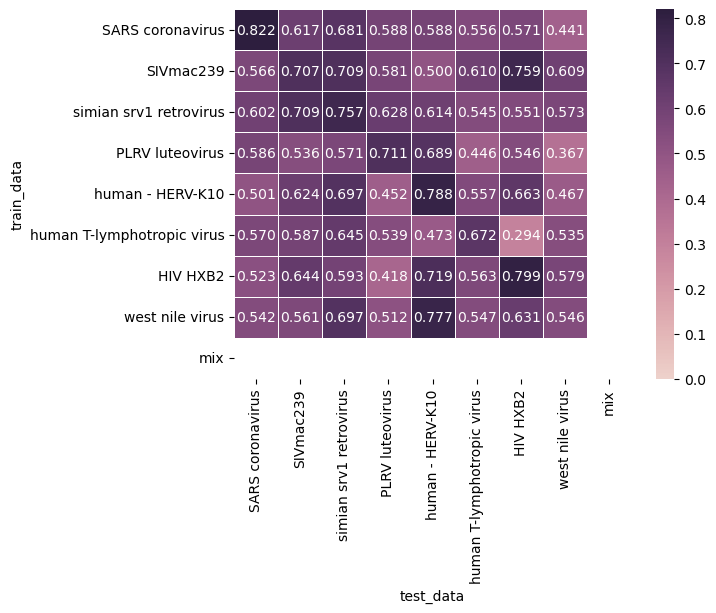

In [18]:
dataset_splits=list(itertools.product(PAPER_CAT, PAPER_CAT))

mikl_perfs = []

for x, y in dataset_splits:
    if x == 'mix' or y == 'mix':
        continue
    if x == y:
        train_data, test_data = train_test_split(feat[feat['prf_class'] == x], test_size=.2, random_state=42)
    else:
        train_data = feat[feat['prf_class'] == x]
        test_data = feat[feat['prf_class'] == y]
    model = XGBClassifier()
    model.fit(train_data[all_cols], train_data['gfp_minus'])
    pred = model.predict_proba(test_data[all_cols])
    roc = roc_auc_score(test_data['gfp_minus'], pred[:,1])
    mikl_perfs.append({
        'train_data': x,
        'test_data': y,
        'roc_auc': roc
    })
mikl_df = pd.DataFrame.from_records(mikl_perfs)
tmp = mikl_df.pivot_table(columns="test_data", index="train_data", values='roc_auc', aggfunc="mean")
tmp = tmp.reindex(index=PAPER_CAT, columns=PAPER_CAT)
sns.heatmap(tmp, annot=True, fmt=".3f", linewidths=0.5, vmin=0, vmax=0.82, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [19]:
mikl_perfs = []

ablation = {
    'all': all_cols,
    'no tRNA availability': seccols+aacols,
    'no RNA secondary structure': taicols+aacols,
    'no AA charge': seccols+taicols,
    'only AA charge': aacols,
    'only tRNA availability': taicols,
    'only RNA secondary structure': seccols
}

for method in ablation:
    for x in PAPER_CAT:
        if x == 'mix':
            train_data, test_data = train_test_split(feat, test_size=.2, random_state=42)
        else:
            train_data = feat[feat['prf_class'] != x]
            test_data = feat[feat['prf_class'] == x]
        model = XGBClassifier()
        model.fit(train_data[ablation[method]], train_data['gfp_minus'])
        pred = model.predict_proba(test_data[ablation[method]])
        mikl_perfs.append({
            'train_data': 'leave_one',
            'test_data': x,
            'roc_auc': roc_auc_score(test_data['gfp_minus'], pred[:,1]),
            'pr_auc': average_precision_score(test_data['gfp_minus'], pred[:,1]),
            'model': f'Mikl {method}'
        })

mikl_df = pd.DataFrame.from_records(mikl_perfs)

In [20]:
mikl_perfs = []

ablation = {
    'all': all_cols,
    'no tRNA availability': seccols+aacols,
    'no RNA secondary structure': taicols+aacols,
    'no AA charge': seccols+taicols,
    'only AA charge': aacols,
    'only tRNA availability': taicols,
    'only RNA secondary structure': seccols
}

for i in range(10):
    for method in ablation:
        for x in PAPER_CAT:
            if x == 'mix':
                train_data, test_data = train_test_split(feat, test_size=.2, random_state=42)
            else:
                train_data = feat[feat['prf_class'] != x]
                test_data = feat[feat['prf_class'] == x]
            model = XGBClassifier(seed = i)
            model.fit(train_data[ablation[method]], train_data['gfp_minus'])
            pred = model.predict_proba(test_data[ablation[method]])
            mikl_perfs.append({
                'train_data': 'leave_one',
                'test_data': x,
                'roc_auc': roc_auc_score(test_data['gfp_minus'], pred[:,1]),
                'pr_auc': average_precision_score(test_data['gfp_minus'], pred[:,1]),
                'model': f'Mikl {method}',
                'iter': i
            })

mikl_df = pd.DataFrame.from_records(mikl_perfs)

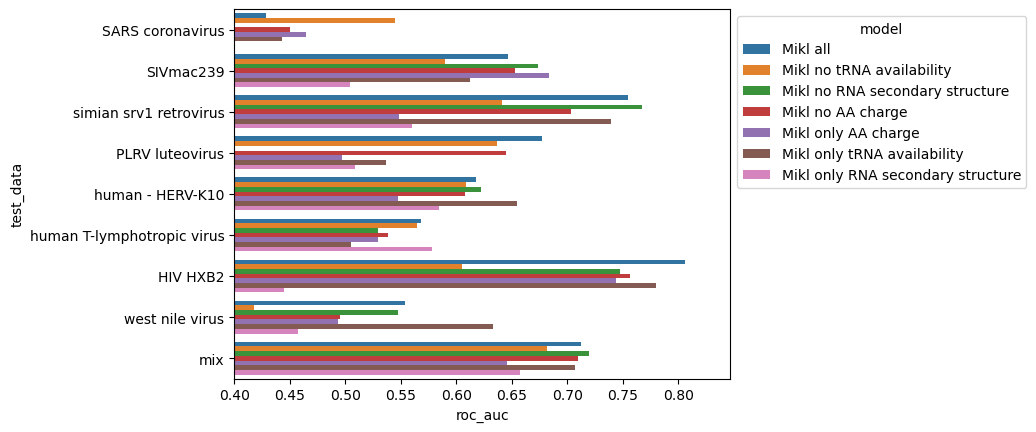

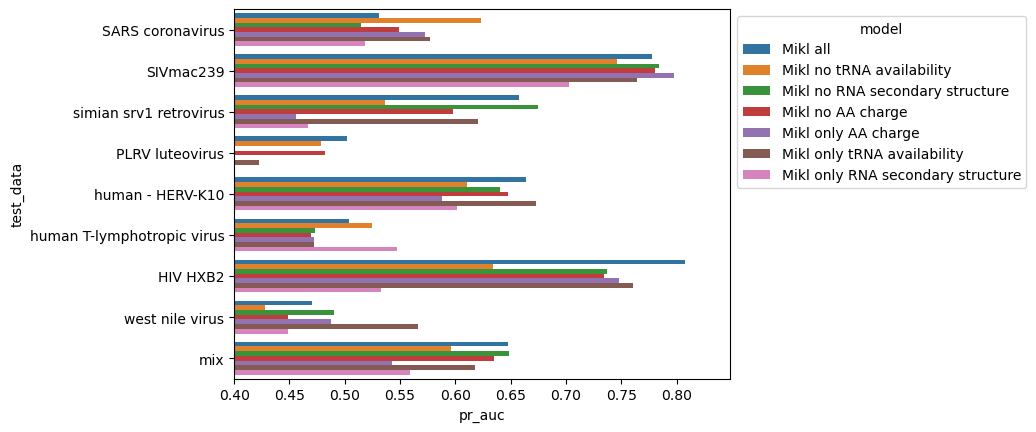

In [21]:
ax = sns.barplot(mikl_df, x='roc_auc', y='test_data', hue='model')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(xmin=0.4)
plt.show()

ax = sns.barplot(mikl_df, x='pr_auc', y='test_data', hue='model')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(xmin=0.4)
plt.show()

In [61]:
# Instantiate the model
model = models.RNACNN_pete()

input_shape = (4, 162)

# Generate summary
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 162]             416
       BatchNorm1d-2              [-1, 32, 162]              64
              ReLU-3              [-1, 32, 162]               0
           Dropout-4              [-1, 32, 162]               0
            Conv1d-5              [-1, 64, 162]           6,208
       BatchNorm1d-6              [-1, 64, 162]             128
              ReLU-7              [-1, 64, 162]               0
           Dropout-8              [-1, 64, 162]               0
            Conv1d-9             [-1, 128, 162]          24,704
      BatchNorm1d-10             [-1, 128, 162]             256
             ReLU-11             [-1, 128, 162]               0
          Dropout-12             [-1, 128, 162]               0
           Conv1d-13             [-1, 256, 162]          98,560
      BatchNorm1d-14             [-1, 2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_df = train.main_loop(
    model_fns=[
        lambda: models.RNACNN_pete()
        #lambda: models.RNACNN(),
        #lambda: models.RNACNN()
        #lambda: models.RNACNN_FC(),
        #lambda: models.RNACNN_GN(),
        #lambda: models.RNACNN_FC_GN(),
    ],
    data=df,
    device=device,
    base_name='cnn',
    lrs=[1e-3],
    #lrs=[1e-2, 1e-3, 1e-4, 1e-5,],
    wds=[0.1],
    #wds=[0.01, 0.05, 0.1, 0.2],
    schedulers = ['CosineAnnealingLR',],
    #schedulers = ['StepLR', 'ExponentialLR', 'CosineAnnealingLR', 'CyclicLR'],
    dataset_splits=PAPER_CAT,
    #baselines=baselines,
    epochs=200,
    loss_mixin=.999,
    data_augment=False 
)

cnn_df = cnn_df.rename(columns={'mix': 'test_data'})


 26%|██▌       | 52/200 [03:28<09:54,  4.01s/it]

Early stopping at epoch 53. Best val loss: 13.2328



  1%|          | 2/200 [00:07<12:57,  3.92s/it]

In [99]:
import torch
print(f"Device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Device: cpu
GPU available: False
GPU count: 0
GPU name: None


In [100]:
cnn_df

,pr_auc,roc_auc,pearson,test_data,lr,wd,model
0,0.714842,0.656523,0.067502,SARS coronavirus,0.001,0.1,RNACNN_pete
1,0.848563,0.680352,0.147350,SIVmac239,0.001,0.1,RNACNN_pete
2,0.568440,0.623836,-0.096070,simian srv1 retrovirus,0.001,0.1,RNACNN_pete
3,0.429407,0.494828,0.010918,PLRV luteovirus,0.001,0.1,RNACNN_pete
4,0.617065,0.541150,-0.006314,human - HERV-K10,0.001,0.1,RNACNN_pete
5,0.498029,0.462495,-0.080788,human T-lymphotropic virus,0.001,0.1,RNACNN_pete
6,0.639812,0.571057,-0.005528,HIV HXB2,0.001,0.1,RNACNN_pete
7,0.749060,0.665004,-0.075631,west nile virus,0.001,0.1,RNACNN_pete
8,0.606114,0.652716,0.054053,mix,0.001,0.1,RNACNN_pete


In [101]:
cnn_df = pd.DataFrame.from_records(cnn_metrics)
cnn_df = cnn_df.rename(columns={'mix': 'test_data'})

NameError: name 'cnn_metrics' is not defined

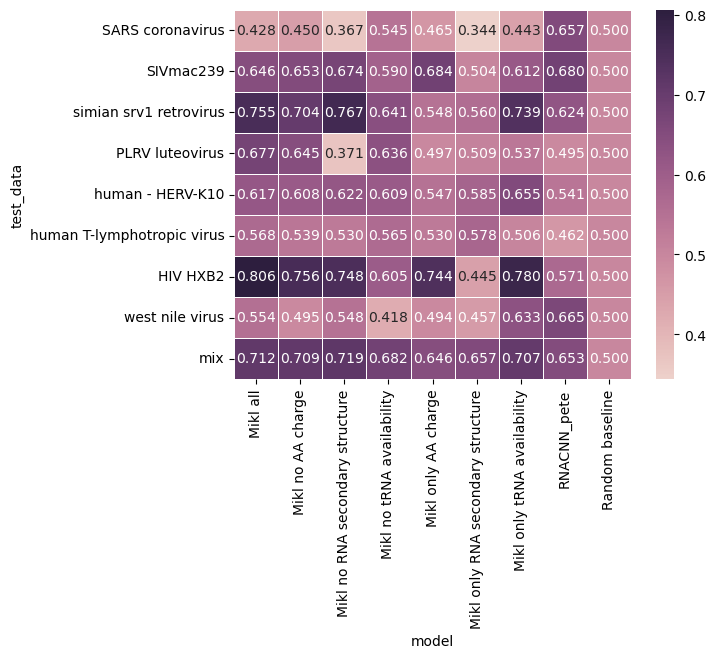

In [102]:
random_baseline = []
for x in PAPER_CAT:
    if x == 'mix':
        train_data, test_data = train_test_split(feat, test_size=.2, random_state=42)
    else:
        train_data = feat[feat['prf_class'] != x]
        test_data = feat[feat['prf_class'] == x]
    random_baseline.append({
        'test_data': x,
        'roc_auc': .5,
        'pr_auc': test_data['gfp_minus'].mean(),
        'model': f'Random baseline'
    })

total = pd.concat([cnn_df, mikl_df, pd.DataFrame.from_records(random_baseline)])


tmp = total.pivot_table(index="test_data", columns="model", values='roc_auc', aggfunc="mean")
tmp = tmp.reindex(columns=sorted(total['model'].unique()), index=PAPER_CAT)
sns.heatmap(tmp, annot=True, fmt=".3f", linewidths=0.5, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [103]:
mikl_df

,train_data,test_data,roc_auc,pr_auc,model,iter
0,leave_one,SARS coronavirus,0.428256,0.530525,Mikl all,0
1,leave_one,SIVmac239,0.646187,0.778023,Mikl all,0
2,leave_one,simian srv1 retrovirus,0.755017,0.657343,Mikl all,0
3,leave_one,PLRV luteovirus,0.677423,0.502195,Mikl all,0
4,leave_one,human - HERV-K10,0.617365,0.664133,Mikl all,0
...,...,...,...,...,...,...
625,leave_one,human - HERV-K10,0.584890,0.601464,Mikl only RNA secondary structure,9
626,leave_one,human T-lymphotropic virus,0.578298,0.547632,Mikl only RNA secondary structure,9
627,leave_one,HIV HXB2,0.444921,0.532595,Mikl only RNA secondary structure,9
628,leave_one,west nile virus,0.457270,0.448908,Mikl only RNA secondary structure,9


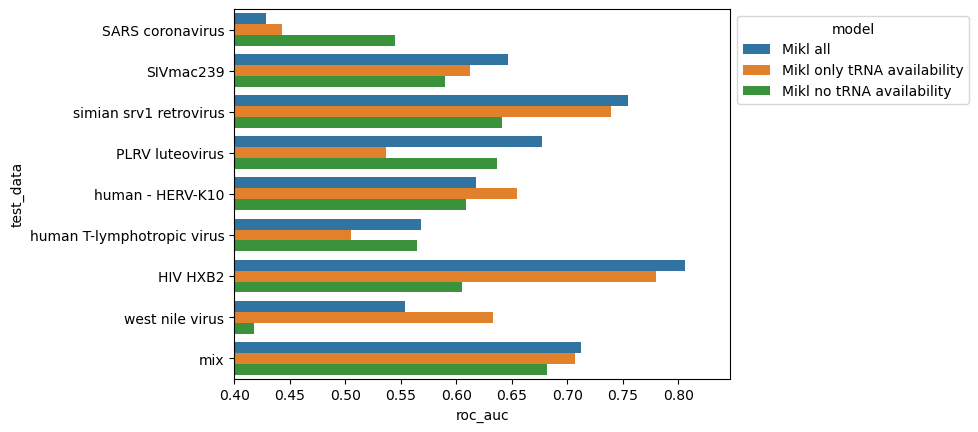

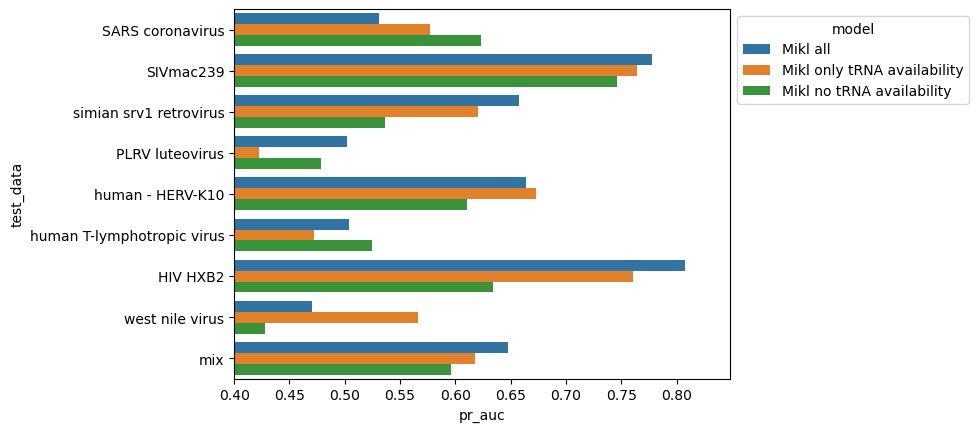

In [104]:
ablation = {
    'all': all_cols,
    'no tRNA availability': seccols+aacols,
    'no RNA secondary structure': taicols+aacols,
    'no AA charge': seccols+taicols,
    'only AA charge': aacols,
    'only tRNA availability': taicols,
    'only RNA secondary structure': seccols
}

MIKL_ORDER = [
    'Mikl all',
    'Mikl only tRNA availability',
    'Mikl no tRNA availability'
]

ax = sns.barplot(mikl_df, x='roc_auc', y='test_data', hue='model', hue_order=MIKL_ORDER)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(xmin=0.4)
plt.show()

ax = sns.barplot(mikl_df, x='pr_auc', y='test_data', hue='model', hue_order=MIKL_ORDER)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(xmin=0.4)
plt.show()

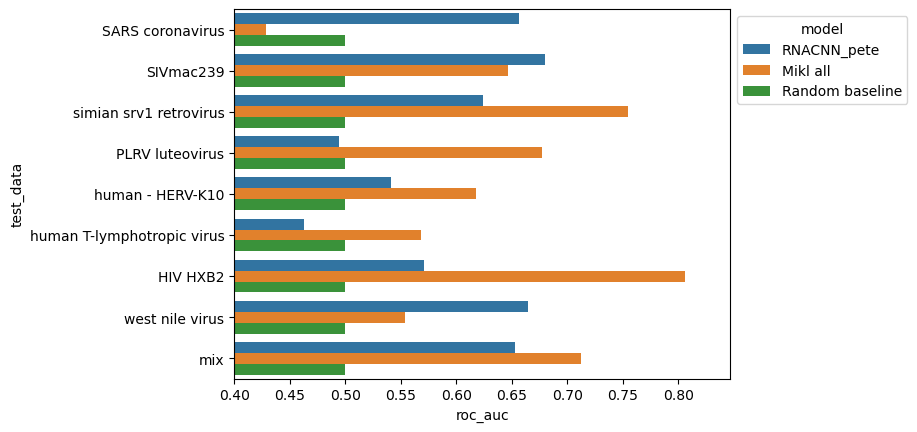

In [105]:
ax = sns.barplot(total, x='roc_auc', y='test_data', hue='model', hue_order=['RNACNN_pete', 'Mikl all', 'Random baseline'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(xmin=0.4)
plt.show()

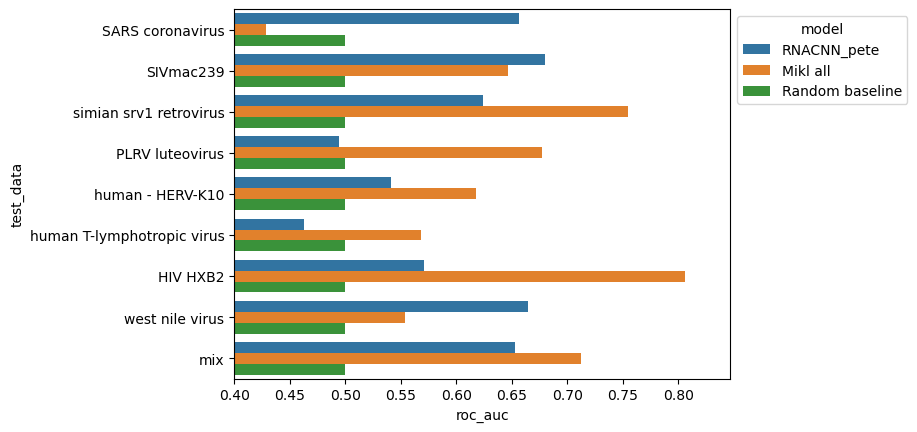

In [106]:
ax = sns.barplot(total, x='roc_auc', y='test_data', hue='model', hue_order=['RNACNN_pete', 'Mikl all', 'Random baseline'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlim(xmin=0.4)
plt.show()

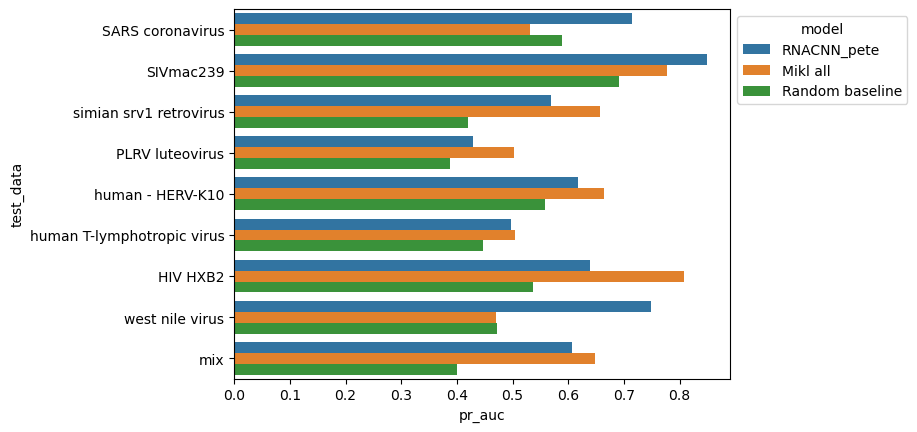

In [108]:
ax = sns.barplot(total, x='pr_auc', y='test_data', hue='model', hue_order=['RNACNN_pete', 'Mikl all', 'Random baseline'])
#plt.xlim(xmin=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

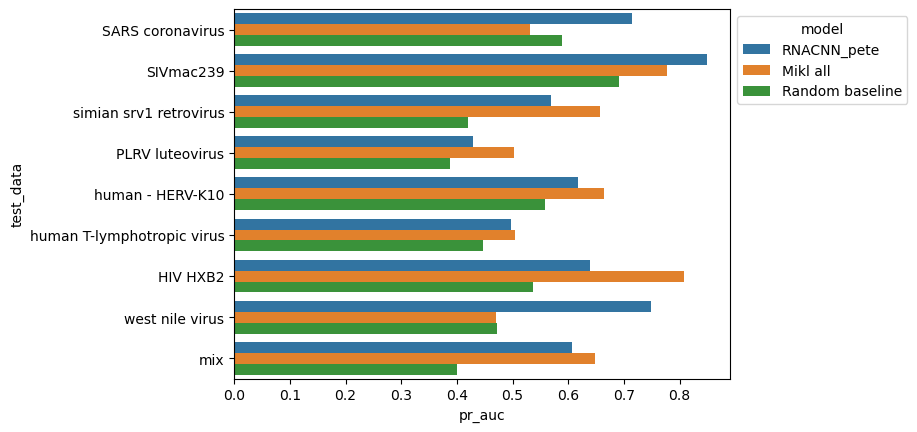

In [107]:
ax = sns.barplot(total, x='pr_auc', y='test_data', hue='model', hue_order=['RNACNN_pete', 'Mikl all', 'Random baseline'])
#plt.xlim(xmin=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [109]:
tmp

model,Mikl all,Mikl no AA charge,Mikl no RNA secondary structure,Mikl no tRNA availability,Mikl only AA charge,Mikl only RNA secondary structure,Mikl only tRNA availability,RNACNN_pete,Random baseline
test_data,,,,,,,,,
SARS coronavirus,0.428256,0.450152,0.366837,0.544783,0.464869,0.343671,0.442954,0.656523,0.5
SIVmac239,0.646187,0.652872,0.673923,0.590171,0.683939,0.504129,0.612193,0.680352,0.5
simian srv1 retrovirus,0.755017,0.703734,0.767047,0.640935,0.548378,0.559998,0.739231,0.623836,0.5
PLRV luteovirus,0.677423,0.644557,0.371190,0.636416,0.497035,0.508596,0.536883,0.494828,0.5
human - HERV-K10,0.617365,0.607751,0.622014,0.608715,0.547399,0.584890,0.654599,0.541150,0.5
human T-lymphotropic virus,0.568152,0.538518,0.529917,0.565077,0.529813,0.578298,0.505630,0.462495,0.5
HIV HXB2,0.806375,0.756397,0.747562,0.605490,0.744281,0.444921,0.779545,0.571057,0.5
west nile virus,0.554232,0.495493,0.547694,0.417844,0.493742,0.457270,0.632761,0.665004,0.5
mix,0.712349,0.709485,0.719344,0.681669,0.645771,0.657201,0.707109,0.652716,0.5


In [110]:
total[['roc_auc', 'model']].groupby('model').mean()

,roc_auc
model,
Mikl all,0.640595
Mikl no AA charge,0.617662
Mikl no RNA secondary structure,0.593947
Mikl no tRNA availability,0.587900
Mikl only AA charge,0.572803
Mikl only RNA secondary structure,0.515442
Mikl only tRNA availability,0.623434
RNACNN_pete,0.594218
Random baseline,0.500000


In [90]:
total[['pr_auc', 'model']].groupby('model').mean()

,pr_auc
model,
Mikl all,0.618069
Mikl no AA charge,0.593623
Mikl no RNA secondary structure,0.588785
Mikl no tRNA availability,0.575258
Mikl only AA charge,0.561873
Mikl only RNA secondary structure,0.529940
Mikl only tRNA availability,0.608174
RNACNN_pete,0.633202
Random baseline,0.500203


In [91]:
import collections

In [92]:
import scipy.stats

In [93]:
acc = []
for m in sorted(total['model'].unique()):
    acc.append({
        'Method': m,
        'Mean AURoC': total[total['model'] == m]['roc_auc'].mean(),
        'Standard Deviation AURoC': total[total['model'] == m]['roc_auc'].std(),
        'Mean AUPR': total[total['model'] == m]['pr_auc'].mean(),
        'Standard Deviation AUPR': total[total['model'] == m]['pr_auc'].std(),
    })
total_perfs = pd.DataFrame.from_records(acc)
total_perfs.sort_values('Mean AUPR', ascending=False)

,Method,Mean AURoC,Standard Deviation AURoC,Mean AUPR,Standard Deviation AUPR
7,RNACNN_pete,0.606392,0.079083,0.633202,0.115053
0,Mikl all,0.640595,0.108848,0.618069,0.117108
6,Mikl only tRNA availability,0.623434,0.105951,0.608174,0.109911
1,Mikl no AA charge,0.617662,0.098527,0.593623,0.111283
2,Mikl no RNA secondary structure,0.593947,0.143749,0.588785,0.136854
3,Mikl no tRNA availability,0.587900,0.071897,0.575258,0.089981
4,Mikl only AA charge,0.572803,0.091068,0.561873,0.127430
5,Mikl only RNA secondary structure,0.515442,0.087981,0.529940,0.086227
8,Random baseline,0.500000,0.000000,0.500203,0.101126


In [94]:
from Bio import SeqIO

In [95]:
def evaluate_sequence(model: nn.Module, transcript: str, window_size: int, start: int = 0, end: Optional[int] = None):
    acc = []
    if end is None:
        end = len(transcript) - window_size
        
    for i in range(start, end, 3):
        acc.append({
            'sequence': str(transcript[i:i+window_size]),
            'start': i,
            'end': i+window_size,
            'peak': int(i + (window_size/2))
        })
    return acc

In [96]:
df.iloc[0].sequence[30:50]

'TTTGCAAAAAAAGCCAGGAC'

In [97]:
df.iloc[0]

gfp_minus_rate                                                 0.86
gfp_plus_rate                                                   NaN
sequence          GATAGGTACCTGGCTGTCGTCCATGCTGTGTTTGCAAAAAAAGCCA...
variant_id                                                    37296
prf_class                                              human - ccr5
gfp_minus                                                     False
gfp_plus                                                      False
Name: 1506, dtype: object